## Imports

The c3aidatalake.py file is required to query the c3.ai COVID-19 database and gather the data samples.
The SciKit Algorithms are divided up into libraries that were tested during Checkpoint 2, and selected algorithms for further exploration

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import c3aidatalake
from datetime import datetime, timedelta

In [2]:
# Machine Learning Algorithms (Only used for testing, can be skipped)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR

In [3]:
# Machine Learning Algorithms (Required)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import SelectFromModel

## Data Preprocessing
Next few cells are used to query from the database, insert new values from existing spreadsheets, and perform feature engineering/feature selection

In [4]:
# Filter all states
locations = c3aidatalake.fetch(
    'outbreaklocation',
    {
        'spec': {
            'filter': 'latestKindergartenPopulation > 0'
        }
    }
)

locations['hospitalBeds'] = locations['hospitalIcuBeds'] + locations['hospitalStaffedBeds'] + locations['hospitalLicensedBeds']
locations = locations.drop(columns=['hospitalIcuBeds', 'hospitalStaffedBeds', 'hospitalLicensedBeds', 'locationType',
                                   'name', 'typeIdent', 'hospitalPrediction.timestamp', 'location.value.id', 'location.timestamp', 'fips.id', 'populationCDS'])
locations.head()

,populationOfAllChildren,laborForceOfAllChildren,latestKindergartenPopulation,id,hospitalBeds
0,4903185.0,2228502,77739.0,Alabama_UnitedStates,35126
1,731545.0,346579,10316.0,Alaska_UnitedStates,3517
2,7278717.0,3587822,79981.0,Arizona_UnitedStates,35150
3,3017804.0,1352185,39257.0,Arkansas_UnitedStates,23440
4,39512223.0,19021894,568947.0,California_UnitedStates,170733


In [5]:
# Data Integration with PopulationData
# Querying the database takes 2 hours to do ... just grab data from actual US Census (2019)

census = pd.read_csv('US_Census2019.csv')
social = pd.read_csv('Social_Census2019.csv')

locations['male'] = census['Male'].astype(float)
locations['female'] = census['Female'].astype(float)
locations['under_18'] = census['Under 18 years'].astype(float)
locations['18_over'] = census['18 years and over'].astype(float)
locations['62_over'] = census['62 years and over'].astype(float)
locations['white'] = census['White'].astype(float)
locations['af_am'] = census['Black or African American'].astype(float)
locations['asian'] = census['Asian'].astype(float)
locations['hispanic'] = census['Hispanic or Latino (of any race)'].astype(float)
locations['disability'] = social['With a disability'].astype(float)
locations.head()

,populationOfAllChildren,laborForceOfAllChildren,latestKindergartenPopulation,id,hospitalBeds,male,female,under_18,18_over,62_over,white,af_am,asian,hispanic,disability
0,4903185.0,2228502,77739.0,Alabama_UnitedStates,35126,2359355.0,2516895.0,1096376.0,3779874.0,989899.0,3320247.0,1299048.0,66270.0,208626.0,781503.0
1,731545.0,346579,10316.0,Alaska_UnitedStates,3517,384915.0,352153.0,184394.0,552674.0,107739.0,476015.0,24205.0,45920.0,51870.0,86874.0
2,7278717.0,3587822,79981.0,Arizona_UnitedStates,35150,3504509.0,3545790.0,1635344.0,5414955.0,1454601.0,5444453.0,317462.0,233213.0,2208663.0,903268.0
3,3017804.0,1352185,39257.0,Arkansas_UnitedStates,23440,1471760.0,1527610.0,704268.0,2295102.0,607439.0,2301044.0,459542.0,45504.0,224130.0,510910.0
4,39512223.0,19021894,568947.0,California_UnitedStates,170733,19526298.0,19757199.0,9022146.0,30261351.0,6769198.0,23453222.0,2274108.0,5692423.0,15327688.0,4101034.0


In [6]:
# Generate Target Values and Correlation Statistics
ids = locations.id.tolist()

end_time = datetime.now().strftime("%Y-%m-%d")
start_time = '2020-04-01' # Moment when COVID cases started rising

target_values = []
for i in range(0, 50, 10):
    confirmcases = c3aidatalake.evalmetrics(
        'outbreaklocation',
        {
            'spec': {
                'ids': ids[i:i+10],
                'expressions': ['JHU_ConfirmedDeaths'],
                'start': start_time,
                'end': end_time,
                'interval': 'DAY',
            }
        }
    )

    confirmcases.drop(columns=['dates'])
    for i in range(0, 10):
        column_cases = confirmcases.iloc[:,i*2+1]
        average_count = column_cases.mean()
        name = column_cases.name.split('.')[0]
        target_values.append([name, average_count])

target_values.sort()

locations['DeathCases'] = [i[1] for i in target_values]
locations.corr()['DeathCases'][:]

populationOfAllChildren         0.836148
laborForceOfAllChildren         0.830899
latestKindergartenPopulation    0.789306
hospitalBeds                    0.850403
male                            0.833641
female                          0.842653
under_18                        0.814763
18_over                         0.843592
62_over                         0.849894
white                           0.827116
af_am                           0.777871
asian                           0.660394
hispanic                        0.690238
disability                      0.829769
DeathCases                      1.000000
Name: DeathCases, dtype: float64

In [7]:
# Convert all continuous values into discrete, categorical values
locations = locations.drop(columns=['id'])
categorical_locations = locations.copy()

description = categorical_locations.describe()
features = ['populationOfAllChildren', 'laborForceOfAllChildren', 'latestKindergartenPopulation', 'hospitalBeds',
           'male', 'female', 'under_18', '18_over', '62_over', 'white', 'af_am', 'asian', 'hispanic', 'disability']

for i in range(len(features)):
    column_select = description[features[i]]
    flag_1 = column_select[4]
    flag_2 = column_select[5]
    flag_3 = column_select[6]
    
    for j in range(50):
        if categorical_locations[features[i]][j] <= flag_1:
            categorical_locations.at[j, features[i]] = 0
        elif categorical_locations[features[i]][j] <= flag_2:
            categorical_locations.at[j, features[i]] = 1
        elif categorical_locations[features[i]][j] <= flag_3:
            categorical_locations.at[j, features[i]] = 2
        else:
            categorical_locations.at[j, features[i]] = 3
            
# Label Death Cases as either low (0) or high (1) in count based on average
mean_cases = description['DeathCases'][1]
for i in range(50):
    if categorical_locations['DeathCases'][i] < mean_cases:
        categorical_locations.at[i, 'DeathCases'] = 0
    else:
        categorical_locations.at[i, 'DeathCases'] = 1

categorical_locations.head()

,populationOfAllChildren,laborForceOfAllChildren,latestKindergartenPopulation,hospitalBeds,male,female,under_18,18_over,62_over,white,af_am,asian,hispanic,disability,DeathCases
0,2.0,2,2.0,2,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,0.0
1,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3.0,2,2.0,2,2.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0,3.0,2.0,1.0
3,1.0,1,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0
4,3.0,3,3.0,3,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0


In [8]:
locations.describe()

,populationOfAllChildren,laborForceOfAllChildren,latestKindergartenPopulation,hospitalBeds,male,female,under_18,18_over,62_over,white,af_am,asian,hispanic,disability,DeathCases
count,5.000000e+01,5.000000e+01,50.00000,50.000000,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,50.000000
mean,6.485307e+06,3.191987e+06,80028.08000,36039.760000,3.191166e+06,3.288937e+06,1.466109e+06,5.013993e+06,1.247069e+06,4.701836e+06,8.182766e+05,3.579323e+05,1.168064e+06,8.051081e+05,5196.774745
std,7.389182e+06,3.555164e+06,98494.94545,37214.008765,3.608525e+06,3.696678e+06,1.691236e+06,5.625077e+06,1.329971e+06,4.856004e+06,9.804115e+05,8.382221e+05,2.698585e+06,8.201103e+05,6703.484599
min,5.787590e+05,2.950450e+05,6126.00000,2988.000000,2.962020e+05,2.848220e+05,1.166540e+05,4.446530e+05,1.077390e+05,3.548470e+05,5.303000e+03,5.025000e+03,1.203800e+04,7.478800e+04,100.737245
25%,1.827712e+06,9.107930e+05,23563.50000,10425.500000,9.126710e+05,9.289505e+05,4.493870e+05,1.442315e+06,3.769098e+05,1.590742e+06,6.813275e+04,3.913275e+04,1.630520e+05,2.459110e+05,850.538265
50%,4.558234e+06,2.088880e+06,55895.00000,27316.000000,2.234954e+06,2.321753e+06,1.052841e+06,3.500379e+06,8.761755e+05,3.331625e+06,3.577215e+05,1.191270e+05,3.792830e+05,6.076830e+05,3048.786990
75%,7.245350e+06,3.832451e+06,86213.50000,39443.750000,3.653603e+06,3.662052e+06,1.641496e+06,5.690244e+06,1.438707e+06,5.574194e+06,1.366770e+06,3.615248e+05,9.146722e+05,9.202632e+05,5775.091837
max,3.951222e+07,1.902189e+07,568947.00000,170733.000000,1.952630e+07,1.975720e+07,9.022146e+06,3.026135e+07,6.769198e+06,2.345322e+07,3.428211e+06,5.692423e+06,1.532769e+07,4.101034e+06,35064.841837


## Model Testing
Test different regression models, requires both sets of Machine Learning libraries to be imported

In [9]:
# Linear Regression
X = locations.iloc[:, :-1]
y = locations.iloc[:, -1]
lin_reg = LinearRegression()
lin_reg_intercept = LinearRegression(fit_intercept=False)
lin_reg_norm = LinearRegression(normalize=True)

# Closer to 1, the better
lin_reg_results = cross_validate(lin_reg, X, y)
lin_reg_intercept_results = cross_validate(lin_reg_intercept, X, y)
lin_reg_norm_results = cross_validate(lin_reg_norm, X, y)
print("Regular linear regression results:", lin_reg_results['test_score'])
print("Intercept linear regression results:", lin_reg_intercept_results['test_score'])
print("Normalized linear regression results:", lin_reg_norm_results['test_score'])

Regular linear regression results: [-3.80479956  0.26128544  0.50543489  0.8667217   0.71592783]
Intercept linear regression results: [-3.91427819  0.25320234  0.54901669  0.86209612  0.64196115]
Normalized linear regression results: [-3.80479956  0.26128544  0.50543489  0.8667217   0.71592783]


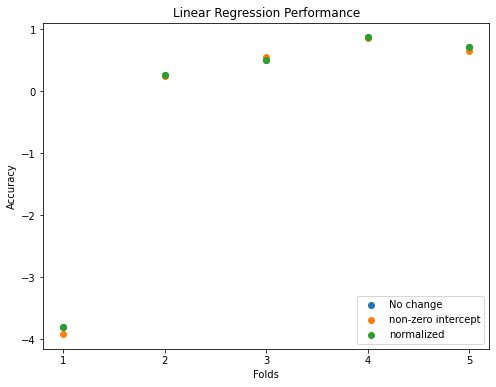

In [10]:
# Linear Regression Graph
folds = [1, 2, 3, 4, 5]
plt.figure(figsize=(8, 6))
plt.scatter(folds, lin_reg_results['test_score'], label='No change')
plt.scatter(folds, lin_reg_intercept_results['test_score'], label='non-zero intercept')
plt.scatter(folds, lin_reg_norm_results['test_score'], label='normalized')
plt.ylabel('Accuracy')
plt.xlabel('Folds')
plt.xticks([1, 2, 3, 4, 5])
plt.title('Linear Regression Performance')
plt.legend()
plt.show()

In [11]:
# Naive Bayes
X = locations.iloc[:, :-1]
y = categorical_locations.iloc[:, -1]
bayes = GaussianNB(priors=[0.72,0.28])

# Closer to 1, the better
bayes_results = cross_validate(bayes, X, y, return_estimator=True)
print(bayes_results['test_score'])

[1.  1.  0.6 1.  0.8]


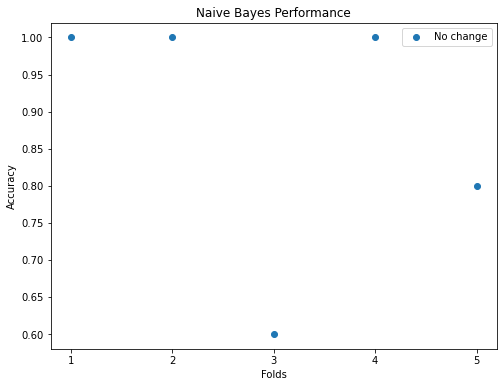

In [12]:
# Naive Bayes Graph
folds = [1, 2, 3, 4, 5]
plt.figure(figsize=(8, 6))
plt.scatter(folds, bayes_results['test_score'], label='No change')
plt.ylabel('Accuracy')
plt.xlabel('Folds')
plt.xticks([1, 2, 3, 4, 5])
plt.title('Naive Bayes Performance')
plt.legend()
plt.show()

In [13]:
# Regression Trees
X = locations.iloc[:, :-1]
y = locations.iloc[:, -1]
results = [[], [], [], []]
for i in range(2, 21, 2):
    mse_results = cross_validate(DecisionTreeRegressor(criterion='mse', max_depth=i), X, y)
    friedman_mse_results = cross_validate(DecisionTreeRegressor(criterion='friedman_mse', max_depth=i), X, y)
    mae_results = cross_validate(DecisionTreeRegressor(criterion='mae', max_depth=i), X, y)
    results[0].append(mse_results['test_score'].mean())
    results[1].append(friedman_mse_results['test_score'].mean())
    results[2].append(mae_results['test_score'].mean())

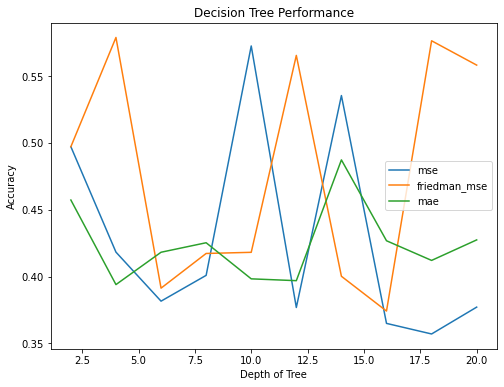

In [14]:
# Regression Trees Graph
plt.figure(figsize=(8, 6))
x_range = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
plt.plot(x_range, results[0], label='mse')
plt.plot(x_range, results[1], label='friedman_mse')
plt.plot(x_range, results[2], label='mae')
plt.ylabel('Accuracy')
plt.xlabel('Depth of Tree')
plt.title('Decision Tree Performance')
plt.legend()
plt.show()

In [15]:
# Random Forest Regression
X = locations.iloc[:, :-1]
y = locations.iloc[:, -1]
rf_regressor = RandomForestRegressor()
results = [[[], []], [[], []], [[], []]]
for i in range(6):
    mse_results_50 = cross_validate(RandomForestRegressor(criterion='mse', max_depth=(i+1), n_estimators=50), X, y)
    mse_results_100 = cross_validate(RandomForestRegressor(criterion='mse', max_depth=(i+1), n_estimators=100), X, y)
    mse_results_150 = cross_validate(RandomForestRegressor(criterion='mse', max_depth=(i+1), n_estimators=150), X, y)
    mae_results_50 = cross_validate(RandomForestRegressor(criterion='mae', max_depth=(i+1), n_estimators=50), X, y)
    mae_results_100 = cross_validate(RandomForestRegressor(criterion='mae', max_depth=(i+1), n_estimators=100), X, y)
    mae_results_150 = cross_validate(RandomForestRegressor(criterion='mae', max_depth=(i+1), n_estimators=150), X, y)
    results[0][0].append(mse_results_50['test_score'].mean())
    results[0][1].append(mae_results_50['test_score'].mean())
    results[1][0].append(mse_results_100['test_score'].mean())
    results[1][1].append(mae_results_100['test_score'].mean())
    results[2][0].append(mse_results_150['test_score'].mean())
    results[2][1].append(mae_results_150['test_score'].mean())

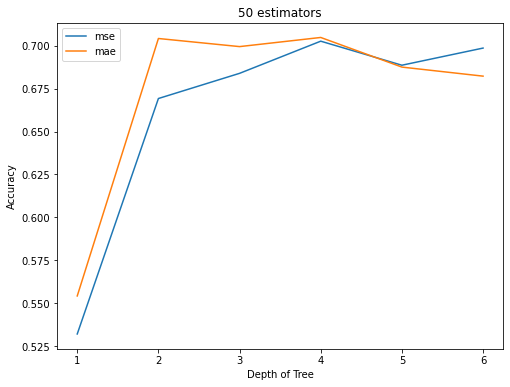

In [16]:
# Random Forest Regression Graph (50 estimators)
plt.figure(figsize=(8, 6))
x_range = [1, 2, 3, 4, 5, 6]
plt.plot(x_range, results[0][0], label='mse')
plt.plot(x_range, results[0][1], label='mae')
plt.ylabel('Accuracy')
plt.xlabel('Depth of Tree')
plt.legend()
plt.title("50 estimators")
plt.show()

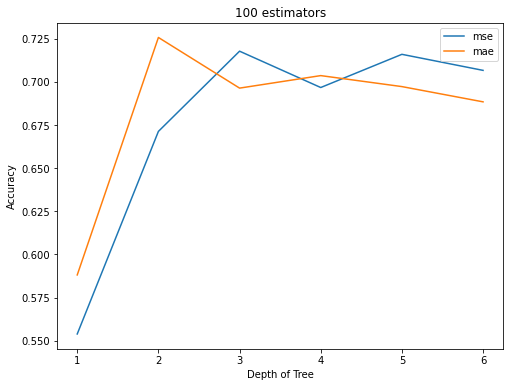

In [17]:
# Random Forest Regression Graph (100 estimators)
plt.figure(figsize=(8, 6))
x_range = [1, 2, 3, 4, 5, 6]
plt.plot(x_range, results[1][0], label='mse')
plt.plot(x_range, results[1][1], label='mae')
plt.ylabel('Accuracy')
plt.xlabel('Depth of Tree')
plt.legend()
plt.title("100 estimators")
plt.show()

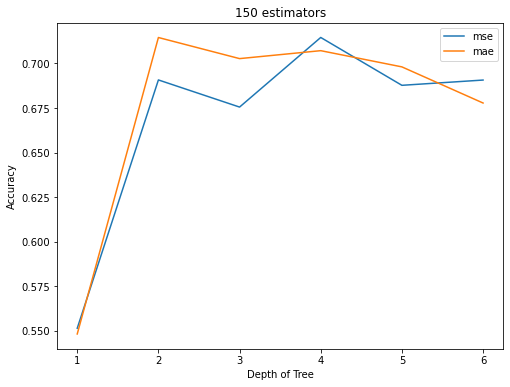

In [18]:
# Random Forest Regression Graph (150 estimators)
plt.figure(figsize=(8, 6))
x_range = [1, 2, 3, 4, 5, 6]
plt.plot(x_range, results[2][0], label='mse')
plt.plot(x_range, results[2][1], label='mae')
plt.ylabel('Accuracy')
plt.xlabel('Depth of Tree')
plt.legend()
plt.title("150 estimators")
plt.show()

In [19]:
# SVR
X = locations.iloc[:, :-1]
y = locations.iloc[:, -1]

rbf_svr_results = cross_validate(SVR(kernel='rbf'), X, y)
sigmoid_svr_results = cross_validate(SVR(kernel='sigmoid'), X, y)

results = []
for i in range(2, 7):
    poly_svr_results = cross_validate(SVR(kernel='poly', degree=i), X, y)
    results.append(poly_svr_results['test_score'].mean())

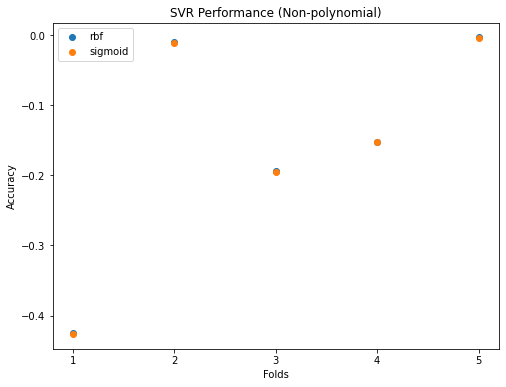

In [20]:
# SVR Graph (Non-poly)
folds = [1, 2, 3, 4, 5]
plt.figure(figsize=(8, 6))
plt.scatter(folds, rbf_svr_results['test_score'], label='rbf')
plt.scatter(folds, sigmoid_svr_results['test_score'], label='sigmoid')
plt.ylabel('Accuracy')
plt.xlabel('Folds')
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.title('SVR Performance (Non-polynomial)')
plt.show()

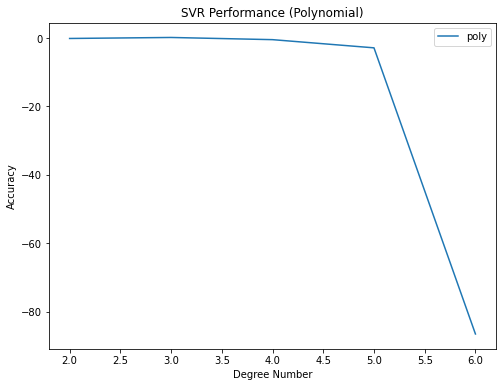

In [21]:
# SVR Graph (poly)
plt.figure(figsize=(8, 6))
x_range = [2, 3, 4, 5, 6]
plt.plot(x_range, results, label='poly')
plt.ylabel('Accuracy')
plt.xlabel('Degree Number')
plt.title('SVR Performance (Polynomial)')
plt.legend()
plt.show()

In [22]:
# Gradient Boosting Regressor
X = locations.iloc[:, :-1]
y = locations.iloc[:, -1]

results = [[], [], []]
# Closer to 1, the better
for i in range(2, 7):
    results_50 = cross_validate(GradientBoostingRegressor(n_estimators=50, max_depth=i), X, y)
    results_100 = cross_validate(GradientBoostingRegressor(n_estimators=100, max_depth=i), X, y)
    results_150 = cross_validate(GradientBoostingRegressor(n_estimators=150, max_depth=i), X, y)
    results[0].append(results_50['test_score'].mean())
    results[1].append(results_100['test_score'].mean())
    results[2].append(results_150['test_score'].mean())

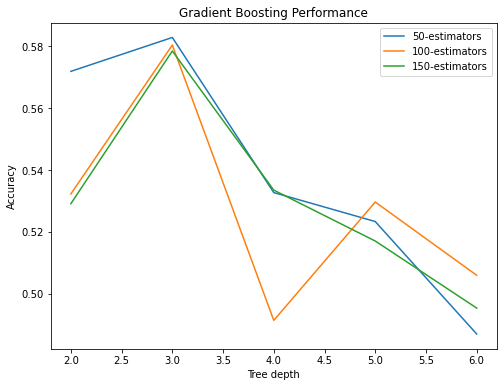

In [23]:
# Gradient Boosting Regressor Graph
plt.figure(figsize=(8, 6))
x_range = [2, 3, 4, 5, 6]
plt.plot(x_range, results[0], label='50-estimators')
plt.plot(x_range, results[1], label='100-estimators')
plt.plot(x_range, results[2], label='150-estimators')
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.title('Gradient Boosting Performance')
plt.legend()
plt.show()

In [24]:
# AdaBoost Regressor
X = locations.iloc[:, :-1]
y = locations.iloc[:, -1]

results = [[], [], []]
for i in range(50, 101, 10):
    linear_result = cross_validate(AdaBoostRegressor(n_estimators=i, loss='linear'), X, y)
    square_result = cross_validate(AdaBoostRegressor(n_estimators=i, loss='square'), X, y)
    exponential_result = cross_validate(AdaBoostRegressor(n_estimators=i, loss='exponential'), X, y)
    results[0].append(linear_result['test_score'].mean())
    results[1].append(square_result['test_score'].mean())
    results[2].append(exponential_result['test_score'].mean())

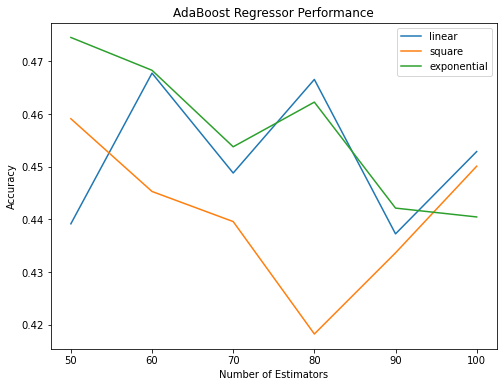

In [25]:
# AdaBoost Regressor Graph
plt.figure(figsize=(8, 6))
x_range = [50, 60, 70, 80, 90, 100]
plt.plot(x_range, results[0], label='linear')
plt.plot(x_range, results[1], label='square')
plt.plot(x_range, results[2], label='exponential')
plt.ylabel('Accuracy')
plt.xlabel('Number of Estimators')
plt.title('AdaBoost Regressor Performance')
plt.legend()
plt.show()

## Model Optimization
Both Random Forest and Gradient Boosting were used for optimization, the next few cells focus on finding the best data set and model parameters for the best performing model.

In [26]:
# Training Modification
X = locations.copy()
X = X.drop(columns=['populationOfAllChildren', 'laborForceOfAllChildren', 'latestKindergartenPopulation', 'male', 'female', 'under_18', '18_over', '62_over', 'white', 'af_am', 'disability', 'asian', 'DeathCases'])
y = locations.iloc[:, -1]

In [27]:
# Random Forest Regression Optimization
parameters = {'n_estimators': [50, 1000], 'max_depth': [1, 100], 'min_samples_split': [2,20]}
clf = GridSearchCV(RandomForestRegressor(), parameters)
clf.fit(X, y)

# Best Parameters
print(clf.best_params_)

{'max_depth': 100, 'min_samples_split': 20, 'n_estimators': 1000}


In [28]:
# Gradient Boost Regression Optimization
parameters = {'min_samples_leaf': [1, 10]}
clf = GridSearchCV(GradientBoostingRegressor(n_estimators=250, max_depth=7, min_samples_split=10), parameters)
clf.fit(X, y)

# Best Parameters
print(clf.best_params_)

{'min_samples_leaf': 10}


In [29]:
# Test new Random Forest Regressor with parameter tuning

rf_regressor_base = RandomForestRegressor()
rf_regressor_new = RandomForestRegressor(n_estimators=250, max_depth=7, min_samples_split=10)
results_base = cross_validate(rf_regressor_base, X, y, return_estimator=True)
results_new = cross_validate(rf_regressor_new, X, y, return_estimator=True)
print(results_base['test_score'].mean())
print(results_new['test_score'].mean())

0.7026345371008283
0.7584525875512368


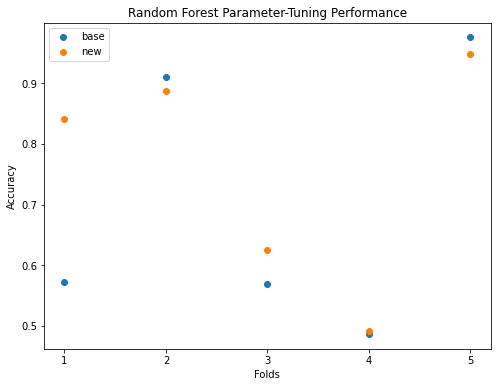

In [30]:
# Optimization Graphing
folds = [1, 2, 3, 4, 5]
plt.figure(figsize=(8, 6))
plt.scatter(folds, results_base['test_score'], label='base')
plt.scatter(folds, results_new['test_score'], label='new')
plt.ylabel('Accuracy')
plt.xlabel('Folds')
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.title('Random Forest Parameter-Tuning Performance')
plt.show()

In [31]:
# Test new Gradient Boosting Regressor with parameter tuning

grad_base = GradientBoostingRegressor()
grad_new = GradientBoostingRegressor(n_estimators=50, max_depth=1, min_samples_split=7)
results_base = cross_validate(grad_base, X, y, return_estimator=True)
results_new = cross_validate(grad_new, X, y, return_estimator=True)
print(results_base['test_score'].mean())
print(results_new['test_score'].mean())

0.5597399690073734
0.7205900806753357


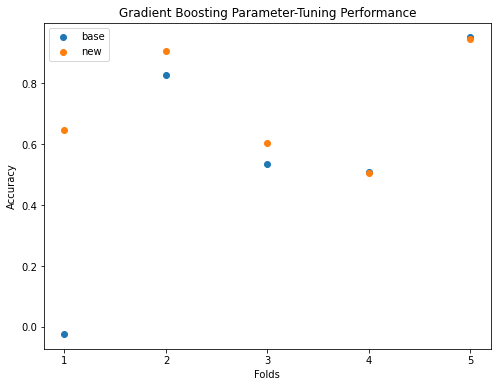

In [32]:
# Optimization Graphing
folds = [1, 2, 3, 4, 5]
plt.figure(figsize=(8, 6))
plt.scatter(folds, results_base['test_score'], label='base')
plt.scatter(folds, results_new['test_score'], label='new')
plt.ylabel('Accuracy')
plt.xlabel('Folds')
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.title('Gradient Boosting Parameter-Tuning Performance')
plt.show()

## Generate and Test Sample Points
After fine-tuning the models, generate points based on value distribution and record values predicted from the model.

In [33]:
grad_model = results_new['estimator'][4]
samples = [
    [27316, 163052],
    [27316, 379283],
    [27316, 914672],
    [10425, 379283],
    [39443, 379283],
    [10425, 163052],
    [39443, 914672]
]
print(grad_model.predict(samples))

[2694.76546593 2819.19361396 3172.72625527 1706.63162497 7436.08325631
 1582.20347694 7789.61589763]
